## Scale dependent errors 

Here we estimate how well the Random forest prediction is working across scales. 

In [1]:
import numpy as np
import xarray as xr

import glidertools as gt
import gsw
import xrft

In [7]:
data_dir = '/Users/dhruvbalwada/OneDrive/sogos_data'
#/Users/dhruvbalwada/OneDrive/sogos_data/data/for_dashboard/sg659
rf_659 = data_dir +'/data/for_dashboard/sg659/RF_MLR_O2_ResultsAtTestPts_659.nc'
rf_660 = data_dir +'/data/for_dashboard/sg660/RF_MLR_O2_ResultsAtTestPts_660.nc'

In [8]:
drf_659 = xr.load_dataset(rf_659)
drf_660 = xr.load_dataset(rf_660)

In [29]:
import time
import calendar

In [25]:
print(drf_659.time.min())
print(drf_659.time.max())

<xarray.DataArray 'time' ()>
array(1.55663111e+09)
<xarray.DataArray 'time' ()>
array(1.56410632e+09)


In [12]:
from scipy.interpolate import griddata

In [10]:
gt.grid_data(drf_659.time, drf_659.pressure, drf_659.ox_measured, bins=np.arange(0,900,10))

KeyboardInterrupt: 

In [91]:
def interp_pres_time(ds_glid, var): 
    pres_ug = ds_glid.pressure[0,:]
    time_ug = ds_glid.time[0,:]
    
    # convert to points values
    points = np.stack([time_ug.values, pres_ug.values],
                       axis=1)
    values = ds_glid[var].values[0,:]
    
    # remove nans
    non_nan = np.logical_and(np.logical_and(~np.isnan(points[:,0]), 
                                      ~np.isnan(points[:,1])),
                                      ~np.isnan(values))
    
    points =points[non_nan,:]
    values =values[non_nan]
    
    # define grid
    pres_grid = np.linspace(0,1000,1001)
    #time_grid = np.arange(119, 207, 0.025)
    #adding the extra days to get rid of nans that are at the edges 
    time_grid = np.arange(ds_glid.time.min()+86400, ds_glid.time.max()-86400,3600)
    grid_p, grid_t = np.meshgrid(pres_grid, time_grid)
    
    temp_grided = griddata(points, values, 
                         (grid_t, grid_p), 
                         method='linear', rescale=True)
    
    return xr.DataArray(temp_grided.T, 
                               dims=["pressure", "time"],
                          coords={"pressure":pres_grid,
                                    "time":time_grid}).rename(var)

In [92]:
O2_meas = interp_pres_time(drf_659, 'ox_measured')

In [101]:
O2_RF = interp_pres_time(drf_659, 'ox_predicted_RF')
O2_MLR = interp_pres_time(drf_659, 'ox_predicted_MLR')

In [93]:
O2_meas

<xarray.DataArray 'ox_measured' (pressure: 1001, time: 2029)>
array([[321.11303858, 321.03047332, 320.94790806, ..., 320.78568225,
        320.9986072 , 321.64709766],
       [321.05222138, 320.95842461, 320.86462783, ..., 320.45961412,
        320.58998523, 321.10282914],
       [320.91210846, 320.83625681, 320.76091379, ..., 320.49705066,
        320.67353017, 321.17987139],
       ...,
       [178.17136523, 178.15864789, 177.9338614 , ...,          nan,
                 nan,          nan],
       [177.27956089, 177.0601042 , 176.84064751, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])
Coordinates:
  * pressure  (pressure) float64 0.0 1.0 2.0 3.0 4.0 ... 997.0 998.0 999.0 1e+03
  * time      (time) float64 1.557e+09 1.557e+09 ... 1.564e+09 1.564e+09

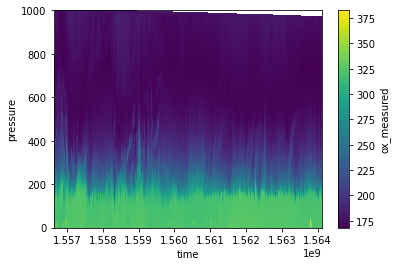

In [61]:
O2_meas.plot()

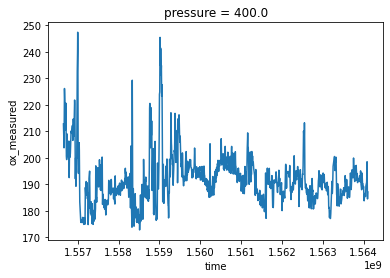

In [62]:
O2_meas.sel(pressure=400, method='nearest').plot()

In [94]:
O2meas_ps = xrft.power_spectrum(O2_meas , 
                               dim=['time']).rename('ox_measured_ps')

In [103]:
O2RF_ps = xrft.power_spectrum(O2_RF , 
                               dim=['time']).rename('ox_RF_ps')

In [104]:
O2MLR_ps = xrft.power_spectrum(O2_MLR , 
                               dim=['time']).rename('ox_MLR_ps')

In [87]:
import matplotlib.pyplot as plt

(1, 100000000.0)

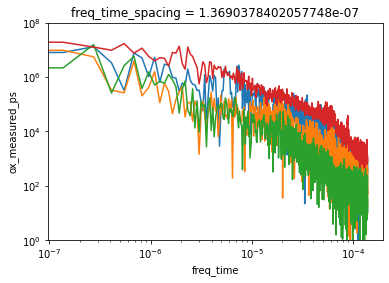

In [98]:
O2meas_ps.sel(pressure=500, method='nearest').plot()
O2meas_ps.sel(pressure=100, method='nearest').plot()
O2meas_ps.sel(pressure=900, method='nearest').plot()

plt.xscale('log')
plt.yscale('log')
plt.ylim([1, 1e8])

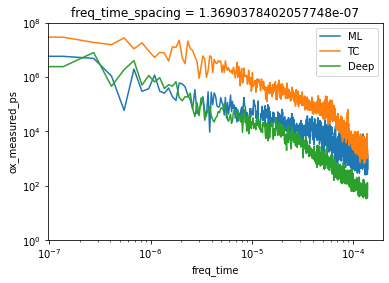

In [100]:
O2meas_ps.sel(pressure=slice(0,100)).mean('pressure').plot(label='ML')
O2meas_ps.sel(pressure=slice(200,500)).mean('pressure').plot(label='TC')
O2meas_ps.sel(pressure=slice(600,900)).mean('pressure').plot(label='Deep')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1, 1e8])
plt.legend()

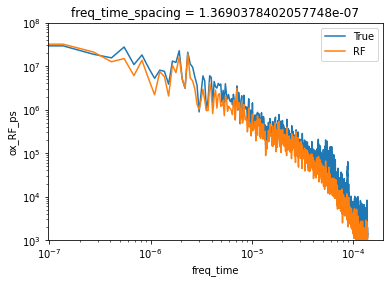

In [109]:
O2meas_ps.sel(pressure=slice(200,500)).mean('pressure').plot(label='True')
O2RF_ps.sel(pressure=slice(200,500)).mean('pressure').plot(label='RF')
#O2MLR_ps.sel(pressure=slice(200,500)).mean('pressure').plot(label='MLR')

plt.xscale('log')
plt.yscale('log')
plt.ylim([1e3, 1e8])
plt.legend()